<a href="https://colab.research.google.com/github/Untick/insects_detection/blob/Romashenkov-Leonid-branch/Romashenkov%20Leonid/LR_PSPNet_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
from tensorflow.keras.models import Model      # Импортируем модель keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K      # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam   # Импортируем оптимайзер
from tensorflow.keras import utils             # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files                 # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt                # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Импортируем модуль image для работы с изображениями
from keras.preprocessing import image
import numpy as np                             # Импортируем библиотеку numpy
import os                                      # Импортируем библиотеку os для работы с файловой системой
from PIL import Image                          # Импортируем модель Image для работы с изображениями
from tensorflow.keras.callbacks import ModelCheckpoint  # Импортируем объект ModelCheckpoint для работы с сохранением модели сети

# Функция, которая смотрит на пересечение областей. Нужна для accuracy
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


# Download & expand data

In [2]:
%pip install -q gdown

In [3]:
import gdown

file_id = '13EP4J8R0zVXHUc31K0cAkJASHRgECEUM'
output_file = 'seg2.tgz'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=13EP4J8R0zVXHUc31K0cAkJASHRgECEUM
To: /content/seg2.tgz
100%|██████████| 9.77M/9.77M [00:00<00:00, 38.7MB/s]


'seg2.tgz'

In [4]:
!tar xzf 'seg2.tgz'
!ls -lh '/content/semantic.v3.2'

total 12K
-rw-r--r-- 1 1000 1000   62 Sep 15 12:41 classes.csv
drwxrwxr-x 2 1000 1000 4.0K Sep 18 12:10 img
drwxrwxr-x 2 1000 1000 4.0K Sep 18 12:11 mask


# GPU (Сначала сменить среду на Т4)

In [5]:
!nvidia-smi

Thu Sep 21 13:59:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       841Mi       9.5Gi       1.0Mi       2.3Gi        11Gi
Swap:             0B          0B          0B


In [7]:
!cat /proc/cpuinfo | grep processor

processor	: 0
processor	: 1


# Классы

In [8]:
import pandas as pd

df = pd.read_csv('/content/semantic.v3.2/classes.csv', index_col= False)
df

,Pixel Value,Class
0,0,background
1,1,bad
2,2,cool
3,3,man
4,4,mean


# Prep Data

In [9]:
trainIm = [] # сейчас тут все картинки

directory = '/content/semantic.v3.2/img'
for filename in sorted(os.listdir(directory)):
    trainIm.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(280, 480))).astype('uint8')) # для всех сетей, кроме Unet with mask используем 280.
                                                                                                                     # для Unet with mask 272

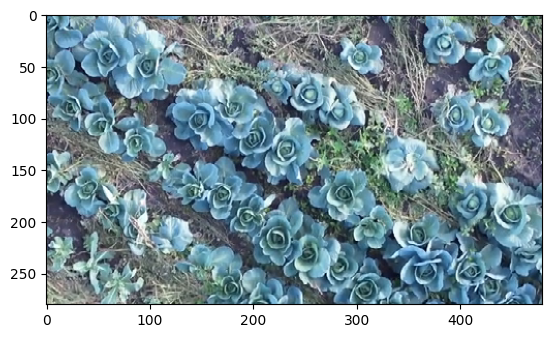

In [10]:
# Выведем пример картинки
plt.imshow(trainIm[6])
plt.show()

In [11]:
trainSeg = [] # сейчас тут все карты сегментации

directory = '/content/semantic.v3.2/mask'
for filename in sorted(os.listdir(directory)):
    trainSeg.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(280, 480))).astype('uint8')) # для всех сетей, кроме Unet with mask используем 280.

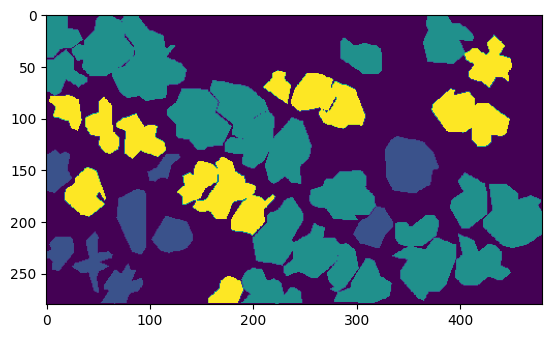

array([0, 1, 2, 3], dtype=uint8)

In [12]:
# Выведем пример yTrain
plt.imshow(trainSeg[6][:,:,0])
plt.show()
np.unique(trainSeg[0][:,:,0])

# Make Train, Val

In [13]:
# Преобразуем каждую из картинок в массив (высота, ширина, количество каналов)
XTrain = []
for img in trainIm:
  x = image.img_to_array(img)
  XTrain.append(x)

In [14]:
# Т.к. картинок мало, то перемешиваем выборку под xTrain, yTrain
import random
numbers = list(range(0,20))
random.shuffle(numbers)
index_train = sorted(numbers[0:15])
index_val = sorted(numbers[15:])
print(index_train)
print(index_val)

[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 14, 15, 16, 18, 19]
[6, 7, 10, 13, 17]


In [15]:
# Преобразуем каждую из картинок в массив (высота, ширина, количество каналов)
xAll = []
for img in trainIm:
  x = image.img_to_array(img)
  xAll.append(x)

In [16]:
xAllnp = np.array(xAll)
xTrain = xAllnp[index_train]    # 15 перемешанных картинок в обучающую
xTest = xAllnp[index_val]       # 5 перемешанных в проверочную
print(xTrain.shape)
print(xTest.shape)

(15, 280, 480, 3)
(5, 280, 480, 3)


In [17]:
# Аналалогично для карт сегментации
yAll = []

for seg in trainSeg:
    y = image.img_to_array(seg)
    yAll.append(y)

In [18]:
yAllnp = np.array(yAll)
yTrain = yAllnp[index_train]
yTest = yAllnp[index_val]
print(yTrain.shape)
print(yTest.shape)

(15, 280, 480, 3)
(5, 280, 480, 3)


**Раскрашиваем сегментированную картинку**

In [19]:
def mask_to_one_hot(mask, num_classes):
    # Создаем массив нулей размерностью (высота, ширина, количество классов)
    one_hot = np.zeros((*mask.shape, num_classes), dtype=np.uint8)
    # Проходимся по классам и устанавливаем соответствующий канал в 1, если маска равна классу
    for class_value in range(num_classes):
        one_hot[..., class_value] = (mask == class_value).astype(np.uint8)
    return one_hot

In [20]:
# Имеем 5 классов [0,1,2,3,4]
num_classes = 5

In [21]:
# Перекрашиваем сегментную карту в цвета по классам
outYTrain = mask_to_one_hot(yTrain, num_classes)
outYTest = mask_to_one_hot(yTest, num_classes)

# PSPNet

In [50]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNet(conv_size = 32, num_classes = 2, input_shape = (272, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(conv_size, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x_c_1 = Activation('relu')(x)
    x = Conv2D(conv_size, (3, 3), padding='same')(x_c_1)
    x = BatchNormalization()(x)
    x_c_2 = Activation('relu')(x)
    x = x_c_2

    x_mp_2 = MaxPooling2D(2)(x)
    x_mp_4 = MaxPooling2D(4)(x)
    x_mp_8 = MaxPooling2D(8)(x)
    #x_mp_16 = MaxPooling2D(16)(x)
    #x_mp_32 = MaxPooling2D(32)(x)

    x_mp_2 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2)
    x_mp_4 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4)
    x_mp_8 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8)
    #x_mp_16 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_16)
    #x_mp_32 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_32)

    x_mp_2 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2)
    x_mp_4 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4)
    x_mp_8 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8)
    #x_mp_16 = Conv2DTranspose(conv_size, (16, 16), strides=(16, 16), activation='relu')(x_mp_16)
    #x_mp_32 = Conv2DTranspose(conv_size, (32, 32), strides=(32, 32), activation='relu')(x_mp_32)

    #fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])
    fin = concatenate([img_input, x_c_1, x_c_2, x_mp_2, x_mp_4, x_mp_8])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv2D(num_classes-1, (3, 3), activation='softmax', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [51]:
modelPSP = PSPNet(64, 6, (280, 480, 3))

In [52]:
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)

In [53]:
modelPSP.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 280, 480, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 280, 480, 64)         256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 280, 480, 64)         0         ['batch_normalization_12

In [25]:
print('xTrain= ',xTrain.shape)
print('outYTrain= ', outYTrain.shape)
print('xTest= ', xTest.shape)
print('outYTest= ', outYTest.shape)

xTrain=  (15, 280, 480, 3)
outYTrain=  (15, 280, 480, 3, 5)
xTest=  (5, 280, 480, 3)
outYTest=  (5, 280, 480, 3, 5)


In [26]:
# Избавляемся от ненужной уже размерности RGB
outYTrain = np.mean(outYTrain, axis=3)
outYTest = np.mean(outYTest, axis=3)
print('otYTrain = ', outYTrain.shape)
print('outYTest = ', outYTest.shape)

otYTrain =  (15, 280, 480, 5)
outYTest =  (5, 280, 480, 5)


In [27]:
# Все размерности согласованы
print('xTrain= ',xTrain.shape)
print('outYTrain= ', outYTrain.shape)
print('xTest= ', xTest.shape)
print('outYTest= ', outYTest.shape)

xTrain=  (15, 280, 480, 3)
outYTrain=  (15, 280, 480, 5)
xTest=  (5, 280, 480, 3)
outYTest=  (5, 280, 480, 5)


In [67]:
history = modelPSP.fit(xTrain, outYTrain, epochs=20, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.5345 - dice_coef: 0.7038
Epoch 1: val_dice_coef did not improve from 0.54292
3/3 [==============================] - 2s 524ms/step - loss: 0.5345 - dice_coef: 0.7038 - val_loss: 1.5659 - val_dice_coef: 0.3645
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.5265 - dice_coef: 0.7085
Epoch 2: val_dice_coef did not improve from 0.54292
3/3 [==============================] - 1s 497ms/step - loss: 0.5265 - dice_coef: 0.7085 - val_loss: 1.5206 - val_dice_coef: 0.3847
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.5093 - dice_coef: 0.7161
Epoch 3: val_dice_coef did not improve from 0.54292
3/3 [==============================] - 1s 515ms/step - loss: 0.5093 - dice_coef: 0.7161 - val_loss: 1.4271 - val_dice_coef: 0.5175
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.5060 - dice_coef: 0.7231
Epoch 4: val_dice_coef did not improve from 0.54292
3/3 [======================

1/1 [==============================] - 0s 24ms/step


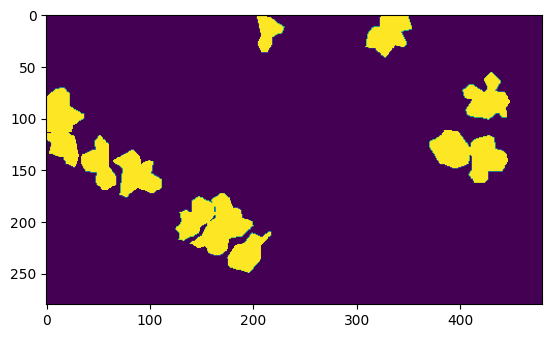

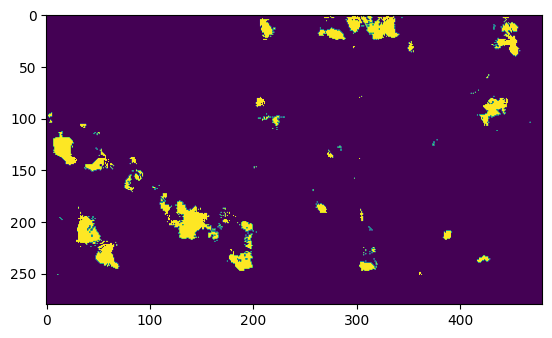

In [80]:
modelPSP.load_weights('/content/psp_model.hdf5') # Подгружаем предобученные веса
pred = modelPSP.predict(xTest[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()

In [28]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNet_2(conv_size = 32, num_classes = 2, input_shape = (272, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(conv_size, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x_c_1 = Activation('relu')(x)

    x = Conv2D(conv_size, (3, 3), padding='same')(x_c_1)
    x = BatchNormalization()(x)
    x_c_2 = Activation('relu')(x)
    x = x_c_2

    x_mp_2 = MaxPooling2D(2)(x)
    x_mp_4 = MaxPooling2D(4)(x)
    x_mp_8 = MaxPooling2D(8)(x)

    x_mp_2 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2)
    x_mp_4 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4)
    x_mp_8 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8)

    x_mp_2 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2)
    x_mp_4 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4)
    x_mp_8 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8)

    fin = concatenate([img_input, x_c_1, x_c_2, x_mp_2, x_mp_4, x_mp_8])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin_c_1 = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin_c_1)
    fin = BatchNormalization()(fin)
    fin_c_2 = Activation('relu')(fin)
    x = fin_c_2

    x_mp_2_1 = MaxPooling2D(2)(x)
    x_mp_4_1 = MaxPooling2D(4)(x)
    x_mp_8_1 = MaxPooling2D(8)(x)

    x_mp_2_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2_1)
    x_mp_4_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4_1)
    x_mp_8_1 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8_1)

    x_mp_2_1 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2_1)
    x_mp_4_1 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4_1)
    x_mp_8_1 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8_1)

    fin = concatenate([img_input, x_c_1, x_c_2, fin, fin_c_1, fin_c_2, x_mp_2, x_mp_4, x_mp_8, x_mp_2_1, x_mp_4_1, x_mp_8_1])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv2D(num_classes-1, (3, 3), activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    return model

In [98]:
modelPSP_2 = PSPNet_2(64, 6, (280, 480, 3))
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model_2.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)
modelPSP_2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_132 (Conv2D)         (None, 280, 480, 64)         1792      ['input_14[0][0]']            
                                                                                                  
 batch_normalization_60 (Ba  (None, 280, 480, 64)         256       ['conv2d_132[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_60 (Activation)  (None, 280, 480, 64)         0         ['batch_normalization_6

In [99]:
history = modelPSP_2.fit(xTrain, outYTrain, epochs=20, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.6001 - dice_coef: 0.3430
Epoch 1: val_dice_coef improved from -inf to 0.08407, saving model to psp_model_2.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 12s 2s/step - loss: 0.6001 - dice_coef: 0.3430 - val_loss: 3.6093 - val_dice_coef: 0.0841
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.3889 - dice_coef: 0.4571
Epoch 2: val_dice_coef did not improve from 0.08407
3/3 [==============================] - 3s 1s/step - loss: 0.3889 - dice_coef: 0.4571 - val_loss: 1.6720 - val_dice_coef: 0.0386
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.3002 - dice_coef: 0.5348
Epoch 3: val_dice_coef improved from 0.08407 to 0.12632, saving model to psp_model_2.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.3002 - dice_coef: 0.5348 - val_loss: 1.4325 - val_dice_coef: 0.1263
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.2622 - dice_coef: 0.5795
Epoch 4: val_dice_coef improved from 0.12632 to 0.26134, saving model to psp_model_2.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.2622 - dice_coef: 0.5795 - val_loss: 1.2014 

1/1 [==============================] - 0s 295ms/step


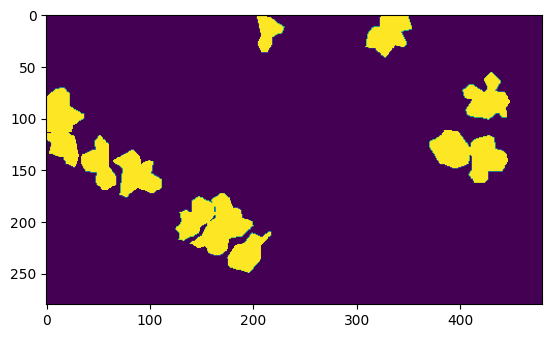

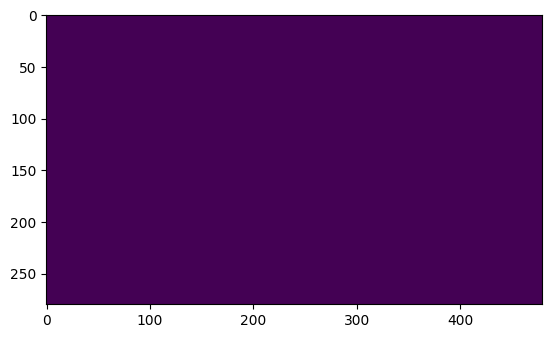

In [100]:
modelPSP_2.load_weights('/content/psp_model_2.hdf5') # Подгружаем предобученные веса
pred = modelPSP_2.predict(xTest[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()

In [34]:
modelPSP_2_64 = PSPNet_2(64, 6, (280, 480, 3))
from pandas.core.arrays import period
checkpoint = ModelCheckpoint('psp_model_2_64.hdf5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', period=1)
modelPSP_2_64.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 280, 480, 3)]        0         []                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 280, 480, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_24 (Ba  (None, 280, 480, 64)         256       ['conv2d_52[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 280, 480, 64)         0         ['batch_normalization_24

In [35]:
history = modelPSP_2_64.fit(xTrain, outYTrain, epochs=20, batch_size=5, validation_data = (xTest, outYTest), callbacks = [checkpoint])

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.6009 - dice_coef: 0.3553
Epoch 1: val_dice_coef improved from -inf to 0.17335, saving model to psp_model_2_64.hdf5
3/3 [==============================] - 11s 1s/step - loss: 0.6009 - dice_coef: 0.3553 - val_loss: 2.9928 - val_dice_coef: 0.1733
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.3829 - dice_coef: 0.4820
Epoch 2: val_dice_coef did not improve from 0.17335
3/3 [==============================] - 3s 1s/step - loss: 0.3829 - dice_coef: 0.4820 - val_loss: 1.5156 - val_dice_coef: 0.0819
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.2944 - dice_coef: 0.5415
Epoch 3: val_dice_coef did not improve from 0.17335
3/3 [==============================] - 3s 1s/step - loss: 0.2944 - dice_coef: 0.5415 - val_loss: 1.3349 - val_dice_coef: 0.0927
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.2568 - dice_coef: 0.5806
Epoch 4: val_dice_coef did not improve from 0.17335
3/3 [==============================] - 3s 1s/step - loss: 0.2568 - dice_coef: 0.5806 - val_loss: 1.0550 - val_dice_coef: 0.1088
Epoch 5/20
3/3 [==============================] - ETA: 0s - loss: 0.2386 - dice_coef: 0.6132
Epoch 5: val_dice_coef improved from 0.17335 to 0.24193, saving model to psp_model_2_64.hdf5
3/3 [=

1/1 [==============================] - 0s 25ms/step


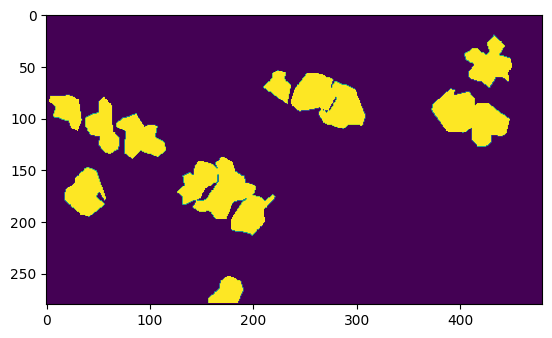

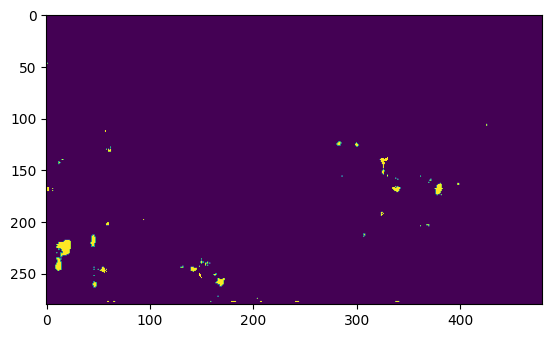

In [44]:
modelPSP_2_64.load_weights('/content/psp_model_2_64.hdf5') # Подгружаем предобученные веса
predPSP_2_64 = modelPSP_2_64.predict(xTest[:1]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 0
plt.imshow(outYTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(predPSP_2_64[n]))[:,:,-1]
plt.imshow(img)
plt.show()